# De-speckling Methods

## Speckle Noise

Speckle noise is a **granular noise** that inherently exists in and degrades the quality of images. It is caused by coherent processing of backscattered signals from multiple distributed targets and is a multiplicative noise.

## Why is it important?
We want to improve image quality. 

Completed 100 / 810 iterations.
Completed 200 / 810 iterations.
Completed 300 / 810 iterations.
Completed 400 / 810 iterations.
Completed 500 / 810 iterations.
Completed 600 / 810 iterations.
Completed 700 / 810 iterations.
Completed 800 / 810 iterations.


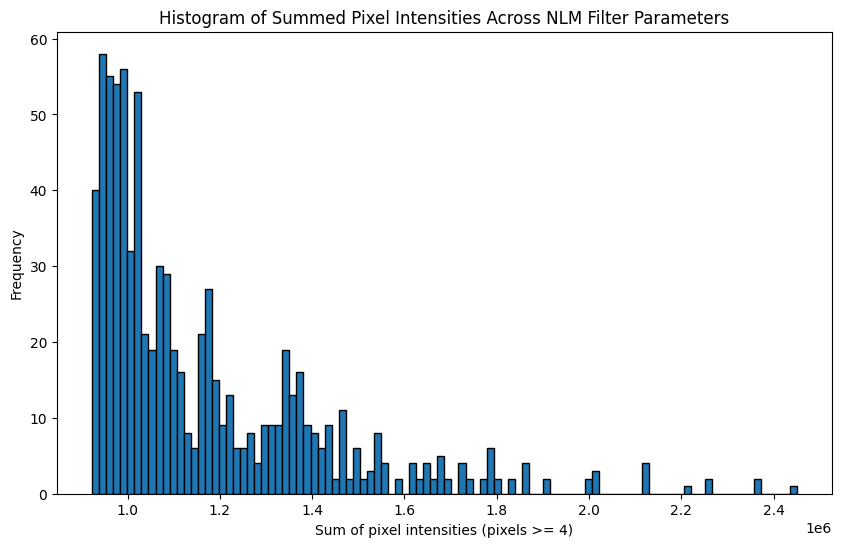

The Median Sum Value for 4 is 1071186.25 +/- 255128.5
1309.0005385875702


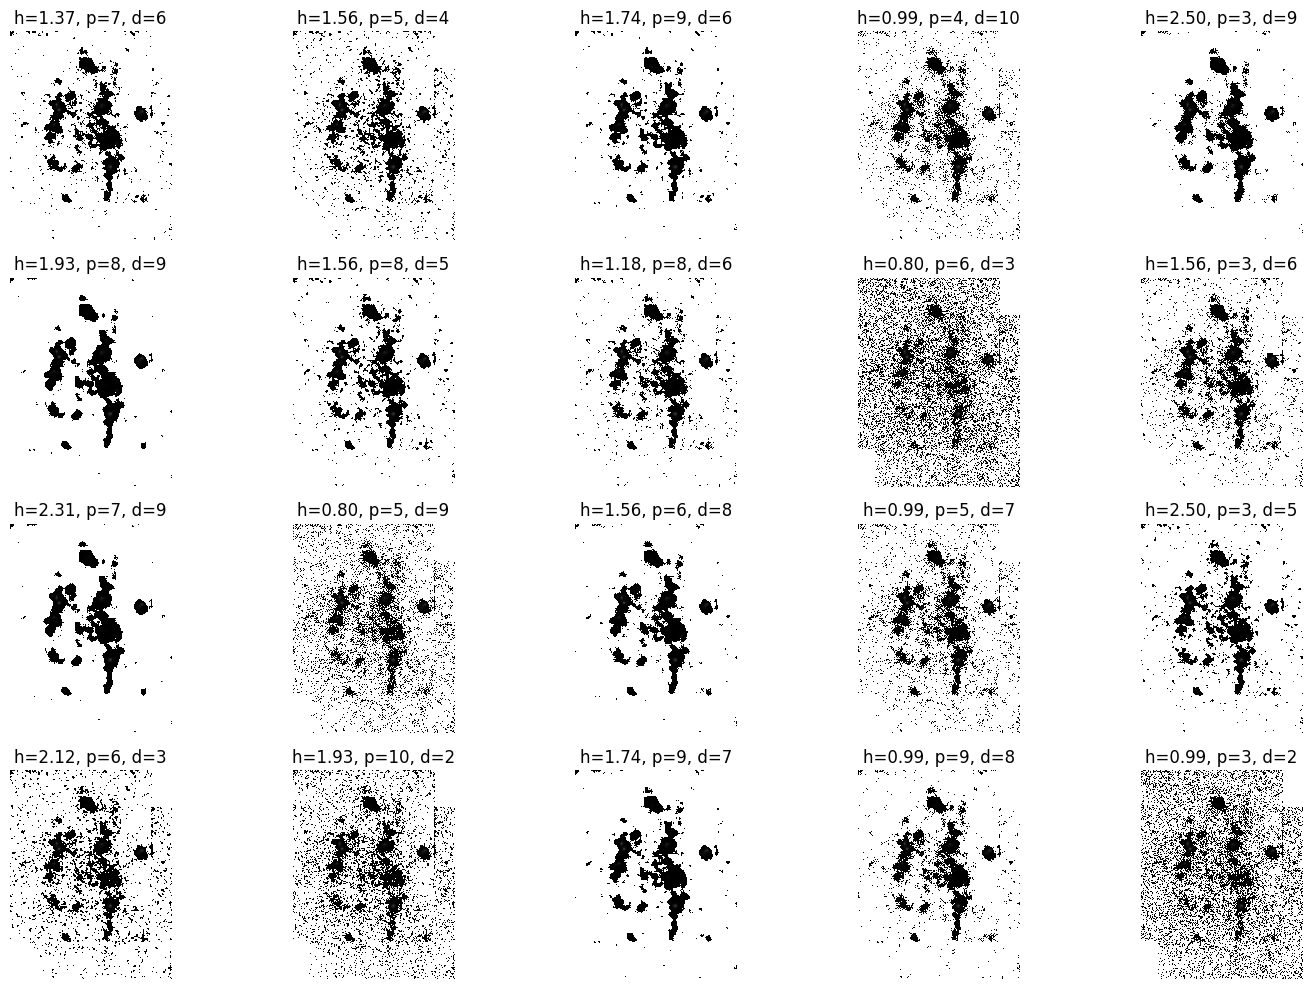

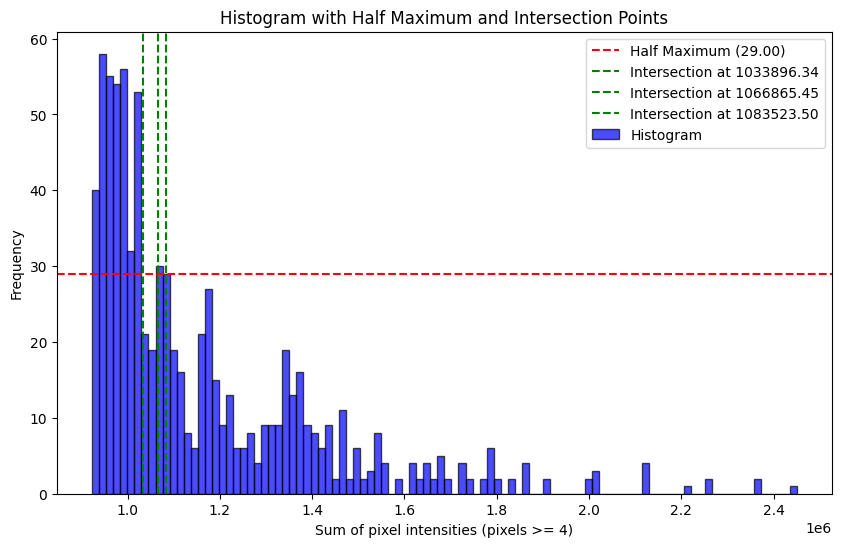

Intersection points at half maximum: [1033896.3437500001, 1066865.4545454546, 1083523.5]


In [4]:

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.restoration import denoise_nl_means, estimate_sigma
import little_things_functions as ltf
import time 
t1 = time.time()

threshold = 4
# -----------------------------
# Load the FITS image
# -----------------------------
def load_fits_image(file_path):
    with fits.open(file_path) as hdul:
        image_data = hdul[0].data

    # Handle byte order if needed.
    if image_data.dtype.byteorder == '>':
        image_data = image_data.byteswap().newbyteorder()

    # Replace NaNs and infinite values with zero.
    image_data = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)
    return image_data

# Specify the path to your FITS file.
fits_file_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 133\d133hmrms.fits"

# Load the full image and then select a region of interest.
image = load_fits_image(fits_file_path)
image_section = image[0:778, 150: 750]

# Optionally, check the image using your log scale plot (if desired)
# ltf.log_scale_plot(image_section, "DDO 87 H-alpha plot (selected portion)", "log scale")

# -----------------------------
# Define NLM Filter with variable parameters.
# -----------------------------
def apply_nl_means_filter(image, h_factor, patch_size, patch_distance):
    # Estimate the noise standard deviation from the image.
    sigma_est = np.mean(estimate_sigma(image, channel_axis=None))
    
    # Apply the NLM denoising algorithm.
    filtered = denoise_nl_means(
        image,
        h=h_factor * sigma_est,
        fast_mode=True,
        patch_size=patch_size,
        patch_distance=patch_distance,
        channel_axis=None
    )
    return filtered

# -----------------------------
# Set up parameter ranges for brute-force exploration.
# -----------------------------
# 10 values for h_factor between 0.8 and 2.5.
h_values = np.linspace(0.8, 2.5, 10)

# Patch sizes from 2 to 10 (inclusive) -> 9 different values.
patch_sizes = np.arange(2, 11)

# Patch distances from 2 to 10 (inclusive) -> 9 different values.
patch_distances = np.arange(2, 11)

sum_values = []  # This will store the sum of pixel intensities for each parameter combination.
params_list = []  # (optional) save parameters used for each iteration.

total_iterations = len(h_values) * len(patch_sizes) * len(patch_distances)
counter = 0

# -----------------------------
# Brute-force loop over all parameter combinations.
# -----------------------------
for h in h_values:
    for patch in patch_sizes:
        for distance in patch_distances:
            # Apply the NLM filter with current parameters.
            filtered = apply_nl_means_filter(image_section, h, patch, distance)
            # Create a mask: set any pixel value less than 4 to NaN.
            masked = np.where(filtered < threshold, np.nan, filtered)
            # Compute the sum ignoring the NaN values.
            sum_val = np.nansum(masked)
            sum_values.append(sum_val)
            params_list.append((h, patch, distance))
            
            counter += 1
            if counter % 100 == 0:
                print(f"Completed {counter} / {total_iterations} iterations.")

# -----------------------------
# Plot a histogram of the calculated sums.
# -----------------------------
plt.figure(figsize=(10, 6))
plt.hist(sum_values, bins=100, edgecolor='black')
plt.xlabel("Sum of pixel intensities (pixels >= 4)")
plt.ylabel("Frequency")
plt.title("Histogram of Summed Pixel Intensities Across NLM Filter Parameters")
plt.show()

print(f"The Median Sum Value for {threshold} is {np.median(sum_values)} +/- {np.std(sum_values)}")

t2 = time.time()

print(t2 - t1)


import random

# -----------------------------
# Show 10 Randomly Filtered Images in a Grid
# -----------------------------
def show_random_filtered_images(image_section, params_list, threshold, num_images=20):
    # Select 10 random parameter combinations from the params_list
    random_params = random.sample(params_list, num_images)
    
    plt.figure(figsize=(15, 10))
    
    for i, params in enumerate(random_params, 1):
        h, patch, distance = params
        filtered = apply_nl_means_filter(image_section, h, patch, distance)
        
        # Create a mask: set any pixel value less than the threshold to NaN
        masked = np.where(filtered < threshold, np.nan, filtered)
        
        plt.subplot(4, 5, i)  # Create a grid with 2 rows and 5 columns
        plt.imshow(masked, cmap='gray', interpolation='none')
        plt.title(f"h={h:.2f}, p={patch}, d={distance}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with your image section and parameters
show_random_filtered_images(image_section, params_list, threshold)

from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Create a histogram
# -----------------------------
hist, bin_edges = np.histogram(sum_values, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Find the maximum value and calculate half maximum
max_value = max(hist)
half_max = max_value / 2

# -----------------------------
# Locate Intersection Points
# -----------------------------
# Find indices where histogram crosses half maximum
above_half_max = hist >= half_max  # Boolean array for values >= half maximum
edges_indices = np.where(np.diff(above_half_max.astype(int)) != 0)[0]  # Transition points

# Interpolate to find the precise values of bin centers at intersections
intersection_points = []
for idx in edges_indices:
    low_bin, high_bin = bin_centers[idx], bin_centers[idx + 1]
    low_val, high_val = hist[idx], hist[idx + 1]
    slope = (high_val - low_val) / (high_bin - low_bin)  # Linear interpolation
    intercept = low_val - slope * low_bin
    x_intersect = (half_max - intercept) / slope
    intersection_points.append(x_intersect)

# -----------------------------
# Plot the histogram and mark intersection points
# -----------------------------
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], alpha=0.7, color='blue', edgecolor='black', label='Histogram')
plt.axhline(half_max, color='red', linestyle='dashed', label=f'Half Maximum ({half_max:.2f})')
for point in intersection_points:
    plt.axvline(point, color='green', linestyle='dashed', label=f'Intersection at {point:.2f}')

plt.xlabel("Sum of pixel intensities (pixels >= 4)")
plt.ylabel("Frequency")
plt.title("Histogram with Half Maximum and Intersection Points")
plt.legend()
plt.show()

# Output intersection points
print(f"Intersection points at half maximum: {intersection_points}")


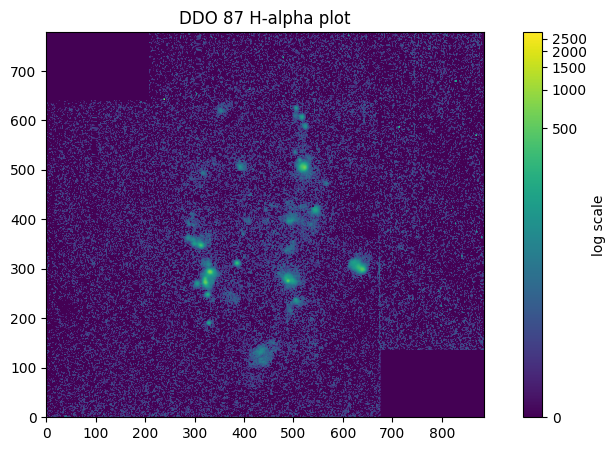

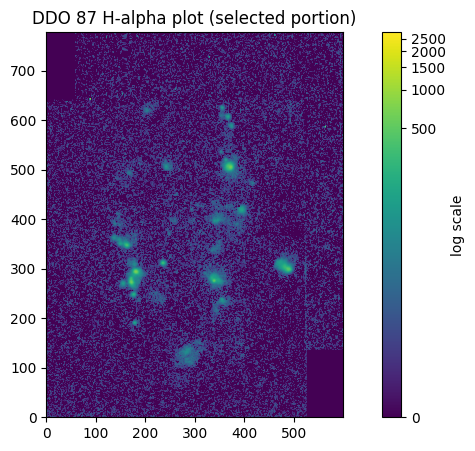

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.io import fits
import os
import little_things_functions as ltf

# Load the image from a FITS file
def load_fits_image(file_path):
    with fits.open(file_path) as hdul:
        image_data = hdul[0].data

    # Handle byte order
    if image_data.dtype.byteorder == '>':
        image_data = image_data.byteswap().newbyteorder()

    # Handle NaNs and infinite values
    image_data = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)
    
    return image_data

# Specify the path to your FITS file
fits_file_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 133\d133hmrms.fits"
# Load the image
image = load_fits_image(fits_file_path)
ltf.log_scale_plot(image, "DDO 87 H-alpha plot", "log scale")

image_section = image[0:778, 150: 750]

ltf.log_scale_plot(image_section,"DDO 87 H-alpha plot (selected portion)", "log scale" )

Statistical Properties of the Selected Region:
Mean: 2.42
Median: 0.56
Standard Deviation: 20.88
Minimum Value: -820.64
Maximum Value: 2814.97


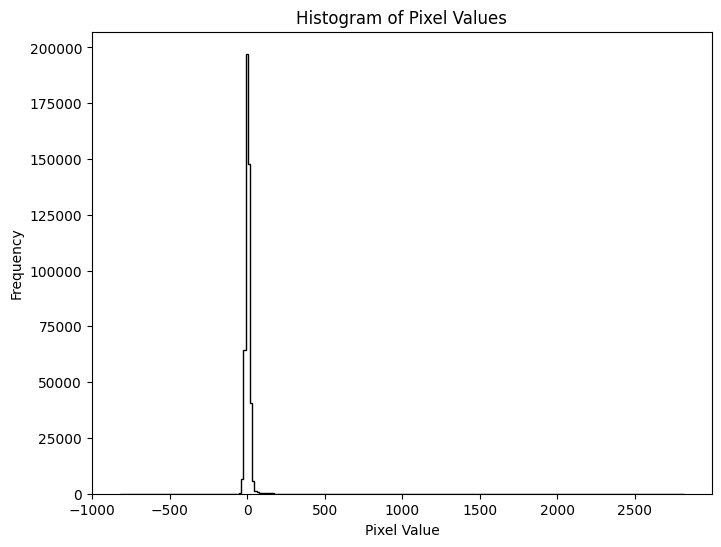

In [3]:
def display_statistics(image_section):
    print("Statistical Properties of the Selected Region:")
    print(f"Mean: {np.mean(image_section):.2f}")
    print(f"Median: {np.median(image_section):.2f}")
    print(f"Standard Deviation: {np.std(image_section):.2f}")
    print(f"Minimum Value: {np.min(image_section):.2f}")
    print(f"Maximum Value: {np.max(image_section):.2f}")

    # Histogram of pixel values
    plt.figure(figsize=(8, 6))
    plt.hist(image_section.ravel(), bins=256, range=(np.min(image_section), np.max(image_section)), histtype='step', color='black')
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

display_statistics(image_section)


## De-speckling Methods:

### 1- Median Filter

**Theory**: The median filter replaces each pixel's value with the median of neighboring pixel values within a specified window size. It effectively removes isolated noise without blurring edges.

parameters: size of the box (3 for example)

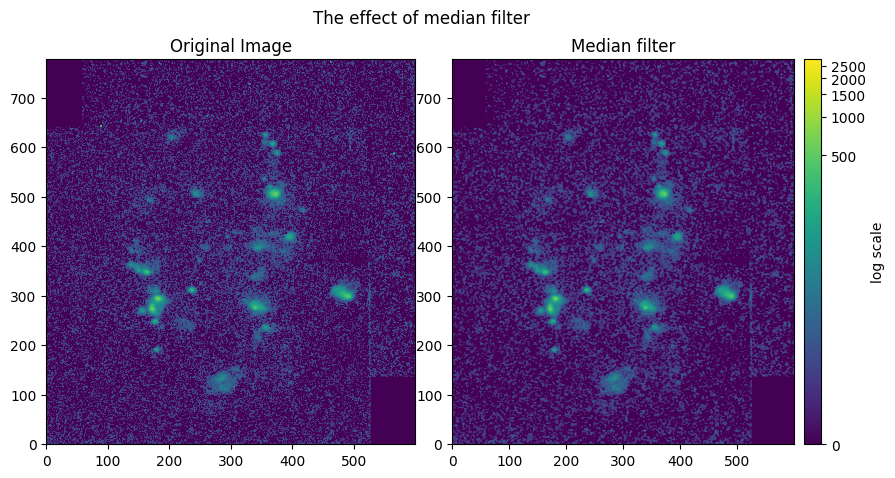

In [4]:
from scipy.ndimage import median_filter

# Apply Median Filter
def apply_median_filter(image, size=3):
    median_filtered = median_filter(image, size=size)
    return median_filtered

median_filtered_image = apply_median_filter(image_section, size=3)

# Display the result
ltf.log_scale_plot_2_images(image_section, median_filtered_image, "Original Image", "Median filter", "The effect of median filter", "log scale", 0.1)


### 2- Lee Filter
**Theory**: 
The Lee filter operates on the principle of local statistics, which involves calculating the mean and variance within a moving window (or kernel) centered around each pixel. These local statistics are used to determine the amount of smoothing applied to each pixel.

1- For each pixel, calculate the local mean (𝜇) and local variance (𝜎2) within a window of size 𝑁×𝑁.

2- Noise Variance Estimation: Estimate the **noise variance (𝜎𝑛2)** from the image. This can be done using the **overall variance of the image or a predefined value based on the imaging system.**

3- Weight Calculation: Calculate the weight (𝑊) for each pixel based on the ratio of the local variance to the sum of the local variance and noise variance:
W = sigma2\sigma2 + sigma_n^2

4- Adjust the pixel value (𝐼new) using the local mean and the weight:

𝐼new = 𝜇+𝑊⋅(𝐼−𝜇)

Here, 𝐼 is the original pixel value, and 𝐼new is the filtered pixel value.

parameter = box size

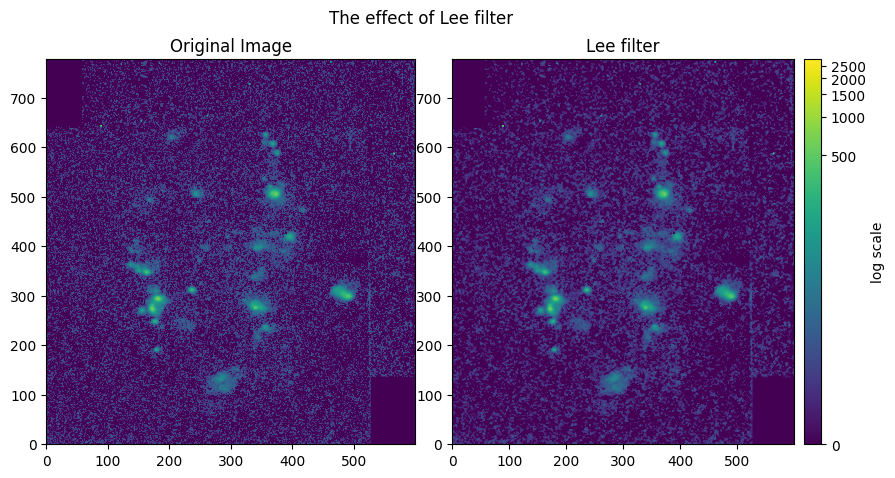

In [5]:
import cv2

def apply_lee_filter(image, size=5):
    img = image.astype(np.float32)
    kernel = np.ones((size, size), np.float32) / (size ** 2)
    local_mean = cv2.filter2D(img, -1, kernel)
    local_var = cv2.filter2D(img ** 2, -1, kernel) - local_mean ** 2
    overall_var = np.mean(local_var)
    img_weights = local_var / (local_var + overall_var + 1e-8)
    lee_filtered = local_mean + img_weights * (img - local_mean)
    return lee_filtered

lee_filtered_image = apply_lee_filter(image_section, size=5)

# Display the result
ltf.log_scale_plot_2_images(image_section, lee_filtered_image, "Original Image", "Lee filter", "The effect of Lee filter", "log scale", 0.1)

### 3- Kuan Filter:
**Theory**: The Kuan Filter is an adaptive filter that, like the Lee Filter, uses local statistics to reduce speckle noise while preserving important image details such as edges and textures. It adapts the amount of smoothing based on the local coefficient of variation within the image.

Calculate the Coefficient of Variation (𝐶𝑖):

C_i^2 = sigma2\mu2

The rest is too complicated to write here

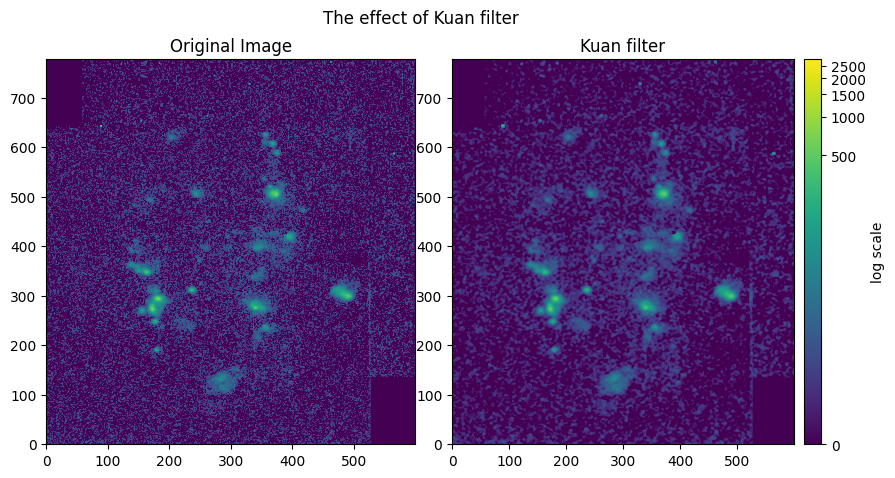

In [6]:
def apply_kuan_filter(image, size=5):
    img = image.astype(np.float32)
    kernel = np.ones((size, size), np.float32) / (size ** 2)
    local_mean = cv2.filter2D(img, -1, kernel)
    local_var = cv2.filter2D(img ** 2, -1, kernel) - local_mean ** 2
    overall_var = np.mean(local_var)
    ci = local_var / (local_mean ** 2 + 1e-8)
    cu = overall_var / (np.mean(local_mean) ** 2 + 1e-8)
    img_weights = (1 / (1 + cu)) * (1 - cu / (ci + cu + 1e-8))
    kuan_filtered = local_mean + img_weights * (img - local_mean)
    return kuan_filtered

kuan_filtered_image = apply_kuan_filter(image_section, size=5)

ltf.log_scale_plot_2_images(image_section, kuan_filtered_image, "Original Image", "Kuan filter", "The effect of Kuan filter", "log scale", 0.1)


### 3- Non-local Means filter
**Theory**: 

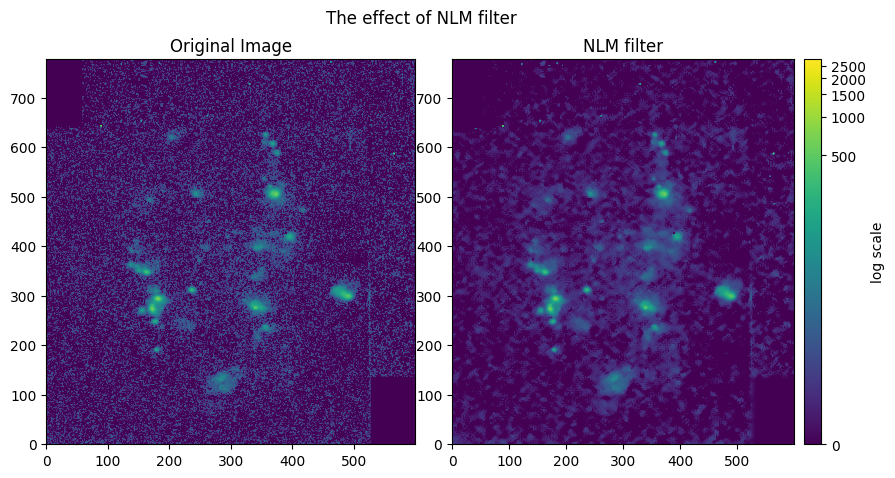

In [7]:
from skimage.restoration import denoise_nl_means, estimate_sigma

# Apply Non-Local Means Filter
def apply_nl_means_filter(image):
    sigma_est = np.mean(estimate_sigma(image, channel_axis=None))
    nlm_filtered = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=5, channel_axis=None)
    return nlm_filtered

nlm_filtered_image = apply_nl_means_filter(image_section)

# Display the result
ltf.log_scale_plot_2_images(image_section, nlm_filtered_image, "Original Image", "NLM filter", "The effect of NLM filter", "log scale", 0.1)


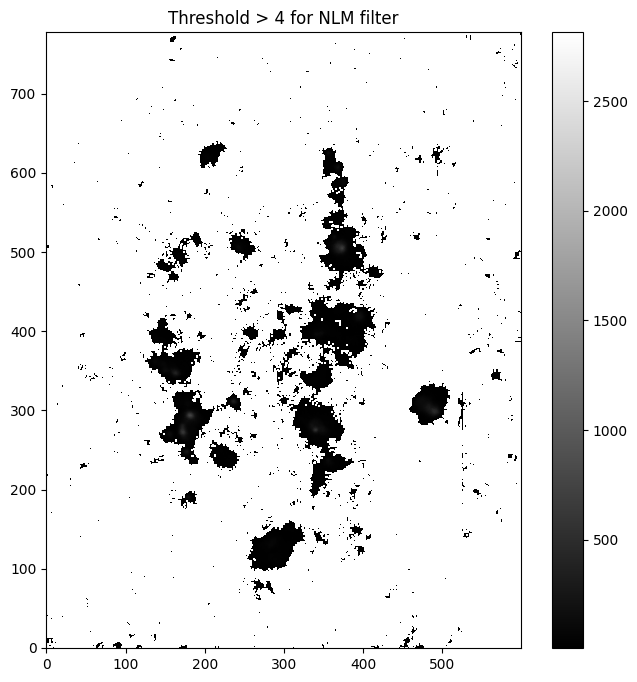

Sum of pixel values above threshold 4: 1156961.62
Estimated error (standard deviation): ±39.11



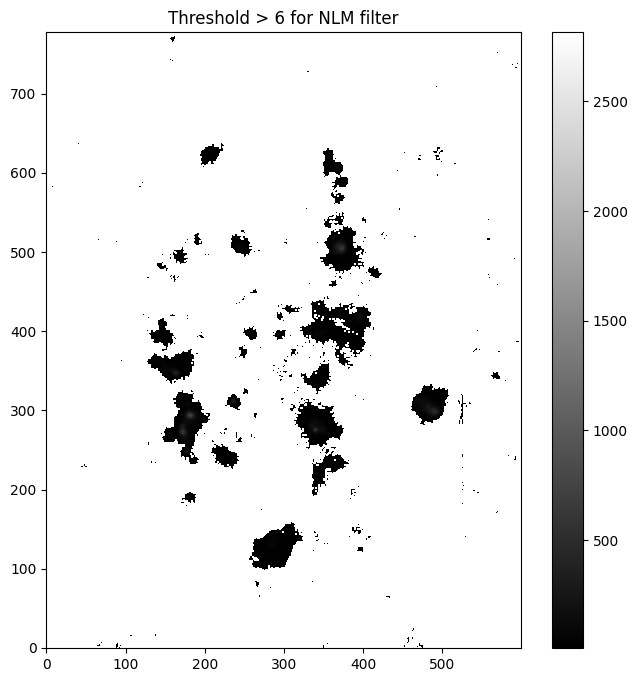

Sum of pixel values above threshold 6: 978596.38
Estimated error (standard deviation): ±52.06



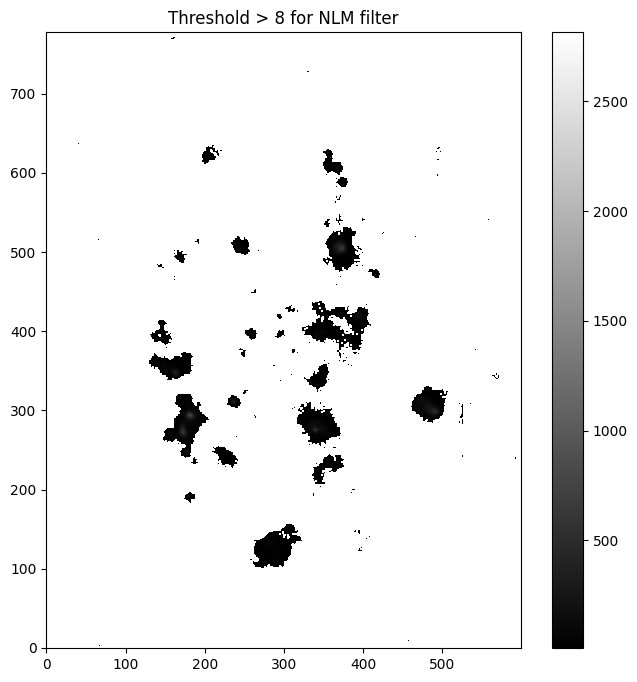

Sum of pixel values above threshold 8: 873718.50
Estimated error (standard deviation): ±63.43



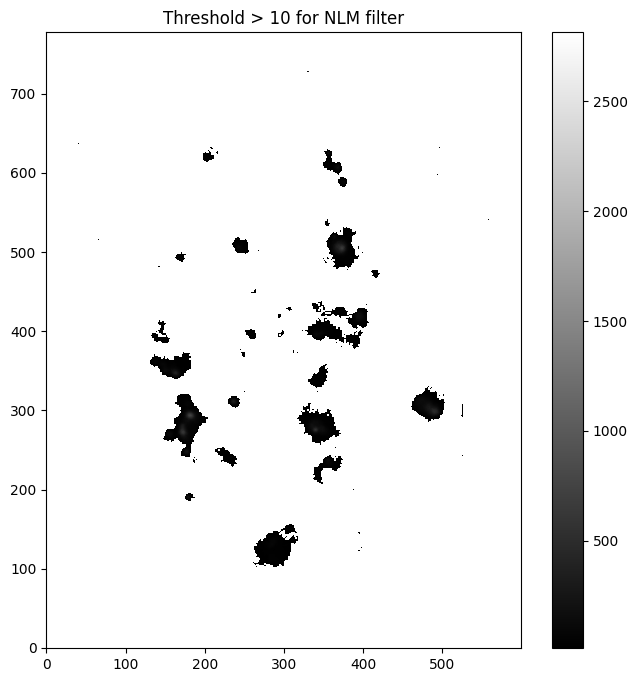

Sum of pixel values above threshold 10: 810187.00
Estimated error (standard deviation): ±72.20



In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define thresholds
threshold_levels = [4, 6, 8, 10]

# Function to apply thresholds and calculate error
def apply_threshold_with_error(image, thresholds, filter_type):
    for threshold in thresholds:
        # Make a copy of the image and apply the threshold
        modified_image = np.copy(image)
        modified_image[modified_image <= threshold] = np.nan
        
        # Plot the modified image
        plt.figure(figsize=(8, 8))
        plt.imshow(modified_image, origin='lower', cmap='gray')
        plt.title(f'Threshold > {threshold} for {filter_type}')
        plt.colorbar()
        plt.show()
        
        # Calculate the sum of pixel values above the threshold
        sum_values = np.nansum(modified_image)
        # Calculate the standard deviation of pixel values above the threshold
        std_dev = np.nanstd(modified_image)
        
        # Print the results
        print(f"Sum of pixel values above threshold {threshold}: {sum_values:.2f}")
        print(f"Estimated error (standard deviation): ±{std_dev:.2f}\n")

# Example usage with your Non-Local Means filtered image
# Replace 'nlm_filtered_image' with your actual image array
apply_threshold_with_error(nlm_filtered_image, threshold_levels, "NLM filter")

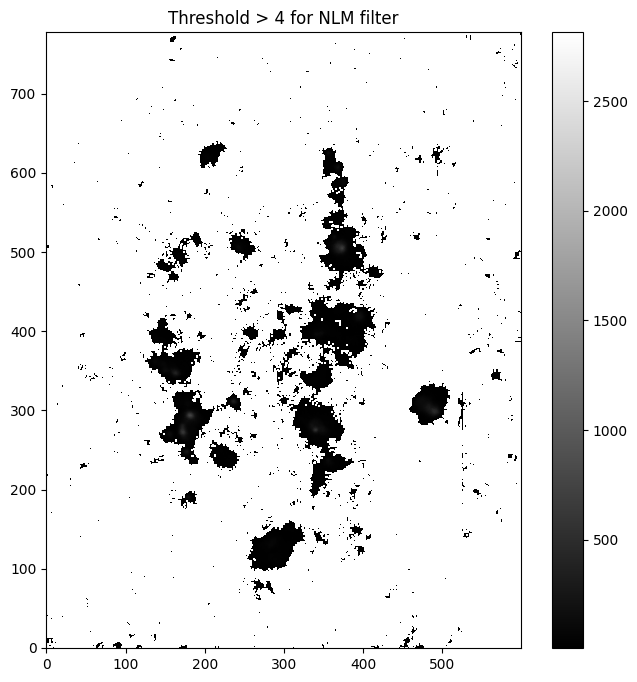

Sum of pixel values above threshold 4: 1156961.62



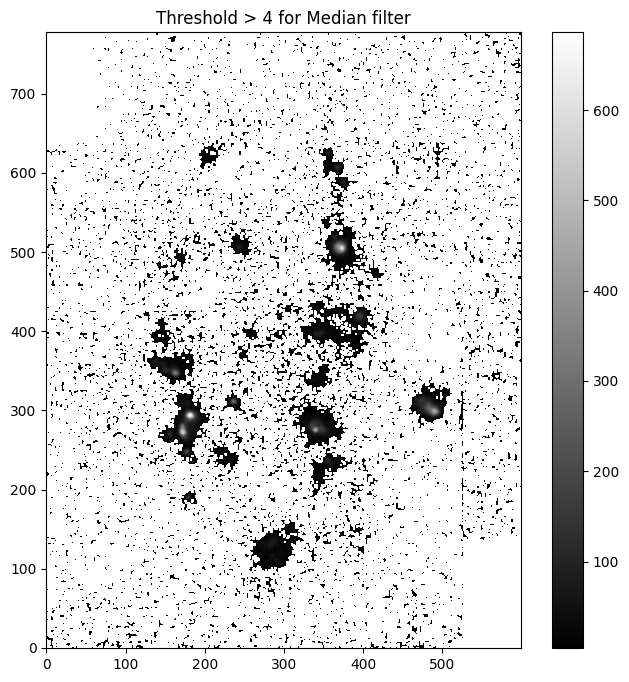

Sum of pixel values above threshold 4: 1813491.25



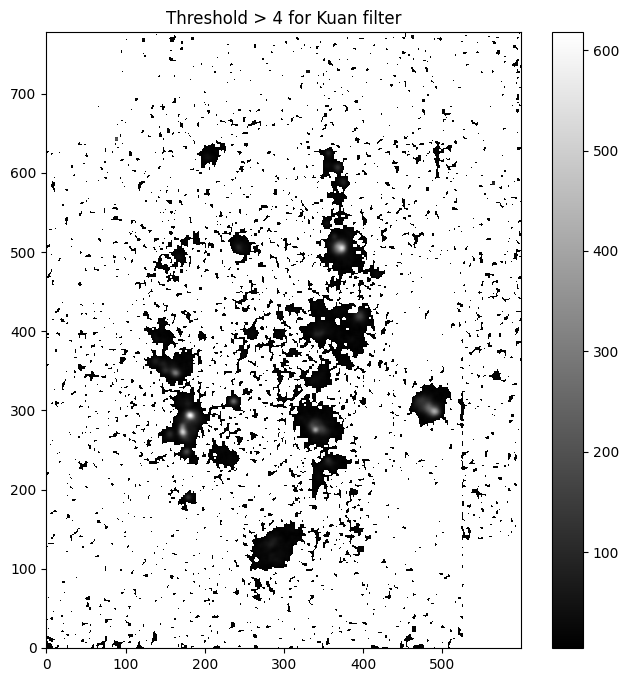

Sum of pixel values above threshold 4: 1332831.38



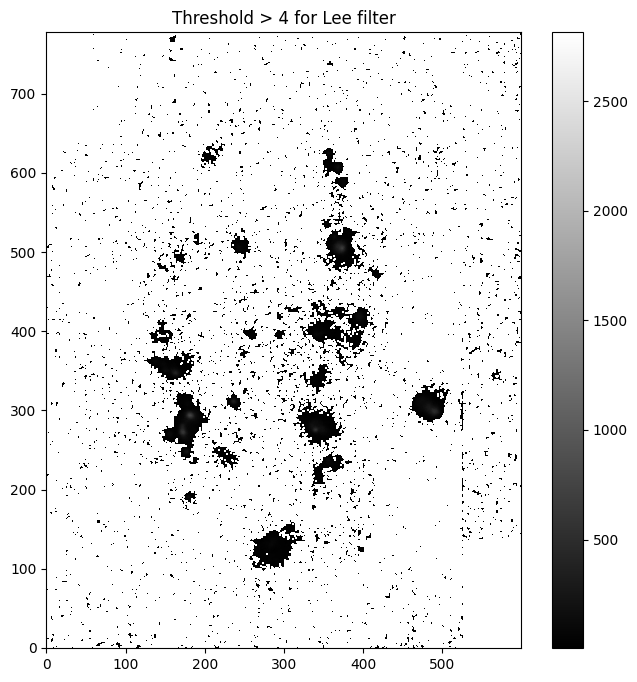

Sum of pixel values above threshold 4: 1860300.00



In [9]:
threshold_levels = [4]

def apply_threshold(image, thresholds, filter_type):
    for threshold in thresholds:
        modified_image = np.copy(image)
        modified_image[modified_image <= threshold] = np.nan
        
        plt.figure(figsize=(8, 8))
        plt.imshow(modified_image, origin='lower', cmap='gray')
        plt.title(f'Threshold > {threshold} for {filter_type}')
        plt.colorbar()
        plt.show()
        
        # Calculate the sum of non-NaN values
        sum_values = np.nansum(modified_image)
        print(f'Sum of pixel values above threshold {threshold}: {sum_values:.2f}\n')

# Apply thresholds to the Non-Local Means filtered image (best result)
apply_threshold(nlm_filtered_image, threshold_levels, "NLM filter")


apply_threshold(median_filtered_image, threshold_levels, "Median filter")

apply_threshold(kuan_filtered_image, threshold_levels, "Kuan filter")

apply_threshold(lee_filtered_image, threshold_levels, "Lee filter")

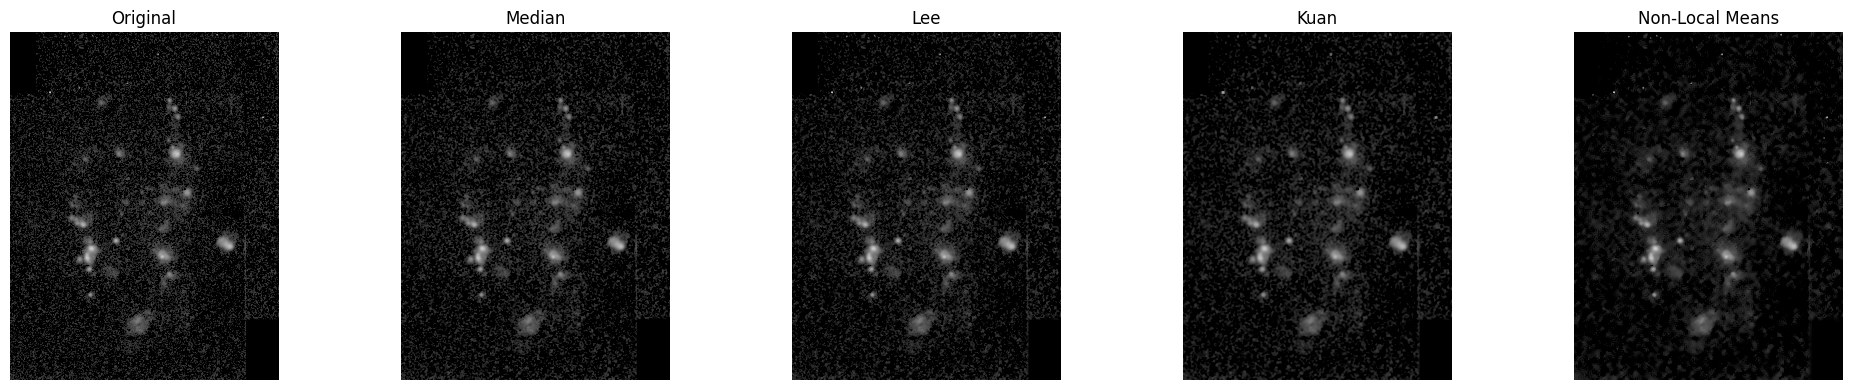

In [10]:
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(vmin=0., stretch=LogStretch())
def compare_filters(original, median, lee, kuan, nlm):
    filters = {
        'Original': original,
        'Median': median,
        'Lee': lee,
        'Kuan': kuan,
        'Non-Local Means': nlm
    }
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for ax, (name, img) in zip(axes, filters.items()):
        
        ax.imshow(img, origin='lower', cmap='gray', norm = norm)
        ax.set_title(name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

compare_filters(image_section, median_filtered_image, lee_filtered_image, kuan_filtered_image, nlm_filtered_image)
